## Begin to Automate Your  Workflow With Functions

Functions can be tricky to learn. In this lesson, you will see how to break down a workflow and create 
a new function that can be used over and over on your data. 

You will want to use functions for this automation assignment. 

In [61]:
# Import necessary packages
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.mask as em
import earthpy.spatial as es
import earthpy.plot as ep


# Get data and set working directory
data = et.data.get_data('ndvi-automation')
os.chdir(os.path.join(et.io.HOME,
                      "earth-analytics",
                      "data"))

In [2]:
# Get a list of each directory
path = os.path.join("ndvi-automation", "sites")

# Get a list of both site directories
sites = glob(path + "/*/")
sites

['ndvi-automation/sites/SJER/', 'ndvi-automation/sites/HARV/']

In [3]:
# Get the site name
site_name = os.path.basename(os.path.normpath(sites[0]))
site_name

'SJER'

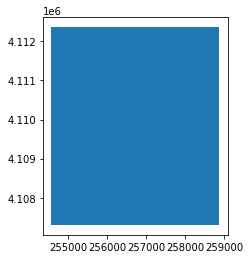

In [4]:
# Open up the shapefile for clipping your landsat data to the study area
vector_dir = os.path.join(sites[0], "vector")

# Open crop boundary
site_boundary_path = os.path.join(vector_dir,  site_name + "-crop.shp")
crop_bound = gpd.read_file(site_boundary_path)
crop_bound.plot()
plt.show()

In [5]:
landsat_dir = os.path.join(sites[0], "landsat-crop")
# This is the crop folder containing all of the .tif files
landsat_dir

'ndvi-automation/sites/SJER/landsat-crop'

In [6]:
# There are many subdirectories in here
landsat_dirs = sorted(glob(os.path.join(landsat_dir, "LC08*")))
landsat_dirs

['ndvi-automation/sites/SJER/landsat-crop/LC080420342017010701T2-SC20181023153321',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017012301T1-SC20181023170015',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017020801T1-SC20181023162521',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017022401T1-SC20181023152103',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017031201T1-SC20181023152108',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017032801T1-SC20181023162825',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017041301T1-SC20181023170020',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017042901T1-SC20181023153144',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017051501T1-SC20181023151959',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017053101T1-SC20181023151941',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017061601T1-SC20181023152417',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017070201T1-SC201810231

In [7]:
# Select just a single directory
adir = landsat_dirs[4]

# Grab bands 4-5 from the directory
band_paths = sorted(glob(os.path.join(adir, "*band*[4-5].tif")))
band_paths

['ndvi-automation/sites/SJER/landsat-crop/LC080420342017031201T1-SC20181023152108/LC08_L1TP_042034_20170312_20170317_01_T1_sr_band4.tif',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017031201T1-SC20181023152108/LC08_L1TP_042034_20170312_20170317_01_T1_sr_band5.tif']

The focus of today is to look at using functions to apply cloud masks. I will create a video
for  next weeks' course that walks you through the above steps of automating
your workflow! Essentially you will want to create some for loops to cycle through
each set of sub directories. 


## Process a Single Band

There are two approaches that you could use here to create NDVI. You could chose to combine both 
bands into a single xarray object or because there are only two bands, you could process each individually.



In [8]:
band_paths

['ndvi-automation/sites/SJER/landsat-crop/LC080420342017031201T1-SC20181023152108/LC08_L1TP_042034_20170312_20170317_01_T1_sr_band4.tif',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017031201T1-SC20181023152108/LC08_L1TP_042034_20170312_20170317_01_T1_sr_band5.tif']

### A Function  Worthy Workflow?

Below is a workflow that you will need to repeat over and over across all bands. 

Normally, when you are developing workflows you write it all out first using  a combination  of 
pseudocode and code. You fill in code and processing gaps as you go.

You can then see places where functions might be useful.
Some people start by deciding what functions they need. This is even more efficient but 
can be challenging if you are newer to data processing and programming.

Functions are useful for many different reasons - a few are below:

1. **They clean up your code following DRY (Dont Repeat Yourself):** ensuring you aren't repeating code. 
2. **They make changes to your code more efficient:** Once you have a function that is used over and over, any changes can be made  within that function! This is a win for you if you need to make updates
3. **They conserve resources by removing objects from memory:** Objects created within a function aren't available in the broader namespace (environment) of your notebook. Objects made wtihin the function are created why the function runs and then thrown away saving your compute resources. This makes your code cleaner and more efficient! 

In [31]:
# Open & clip the data - a single band using rioxarray
band = (rxr.open_rasterio(band_paths[0], masked=True)
        .rio.clip(crop_bound.geometry, from_disk=True)
        .squeeze())

# Specify the valid range of values for landsat
valid_range = (0, 10000)

if valid_range:
    mask = ((band < valid_range[0]) | (band > valid_range[1]))
    band = band.where(~xr.where(mask, True, False))

band

<xarray.DataArray (y: 170, x: 144)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [347., 334., 512., ..., 527., 486.,  nan],
       [416., 421., 579., ..., 544., 481.,  nan],
       ...,
       [589., 702., 611., ..., 698., 713.,  nan],
       [508., 567., 639., ..., 600., 614.,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * x            (x) float64 2.546e+05 2.546e+05 ... 2.588e+05 2.589e+05
  * y            (y) float64 4.112e+06 4.112e+06 ... 4.107e+06 4.107e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [30]:
#  This function has the code from the workflow above
def open_clean_bands(band_path,
                     crop_extent_gdf,
                     valid_range=None,):
    """Open and mask a single landsat band using a pixel_qa layer.

    This is a long summary...
    ...
    
    Parameters
    -----------
    band_path : string
        A path to the array to be opened
    crop_extent : GeoDataFrame
        A GeoDataFrame showing the extent to crop the bands to.
    valid_range : tuple (optional)
        A tuple of min and max range of values for the data. 
        Default = None

    Returns
    -------
    xarray DataArray
        An xarray DataArray with values that should be masked set to 1 
        for True (Boolean)
    """
    
    # Open and clip the band
    band = (rxr.open_rasterio(band_path, masked=True)
            # Using from_disk to speed things up
            .rio.clip(crop_extent_gdf.geometry, from_disk=True)
            .squeeze())

    # Restrict the data range if a valid range tuple is provided
    if valid_range:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band

## Apply your function

Using this function you can now crop and mask a single band in a single step!
Yes you could also chose to process multiple bands in this function or concat the 

xarray objects - there is where you could spend some time optimizing your code 

In [32]:
# Open and clean a single band using a function
band_4 = open_clean_bands(
    band_path=band_paths[0],
    crop_extent=crop_bound,
    # The range of values for landsat can include zeros
    # For this week let's stick with 0-10000
    valid_range=(0, 10000))

## But what about band 5?

There are decisions to be made here. For NDVI calculations you will want to have both  bands. 
You could chose to calculate each manually like this:

In [37]:
# %%timeit

# Open and clean a single band
band_4 = open_clean_bands(
    band_path=band_paths[0],
    crop_extent=crop_bound,
    valid_range=(0, 10000))

# Open and clean a single band
band_5 = open_clean_bands(
    band_path=band_paths[1],
    crop_extent=crop_bound,
    valid_range=(0, 10000))

# Then  calculate NDVI
ndvi = es.normalized_diff(band_5, band_4)

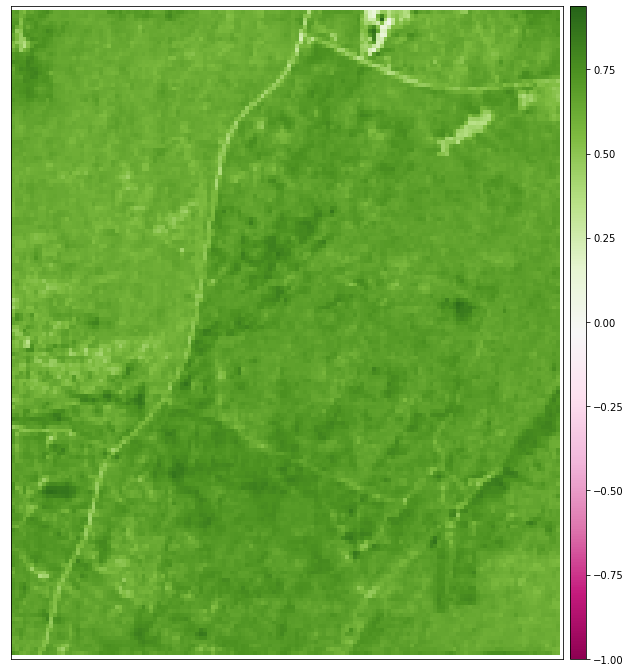

In [38]:
ep.plot_bands(ndvi,
              cmap='PiYG',
              vmin=-1)
plt.show()

Notice below the for loop removes some redundant code. 

In [39]:
# Recall that band_paths is a list of 2 bands - bands 4 and 5
# because  you sorted the data you know what order it will be in
band_paths

['ndvi-automation/sites/SJER/landsat-crop/LC080420342017031201T1-SC20181023152108/LC08_L1TP_042034_20170312_20170317_01_T1_sr_band4.tif',
 'ndvi-automation/sites/SJER/landsat-crop/LC080420342017031201T1-SC20181023152108/LC08_L1TP_042034_20170312_20170317_01_T1_sr_band5.tif']

In [50]:
all_bands = []
for aband in band_paths:
    print("Opening up", aband)
    cleaned_band = open_clean_bands(
        band_path=aband,
        crop_extent=crop_bound,
        valid_range=(0, 10000))
    all_bands.append(cleaned_band)


# Then calculate NDVI
ndvi_2 = es.normalized_diff(all_bands[1], all_bands[0])

Opening up ndvi-automation/sites/SJER/landsat-crop/LC080420342017031201T1-SC20181023152108/LC08_L1TP_042034_20170312_20170317_01_T1_sr_band4.tif
Opening up ndvi-automation/sites/SJER/landsat-crop/LC080420342017031201T1-SC20181023152108/LC08_L1TP_042034_20170312_20170317_01_T1_sr_band5.tif


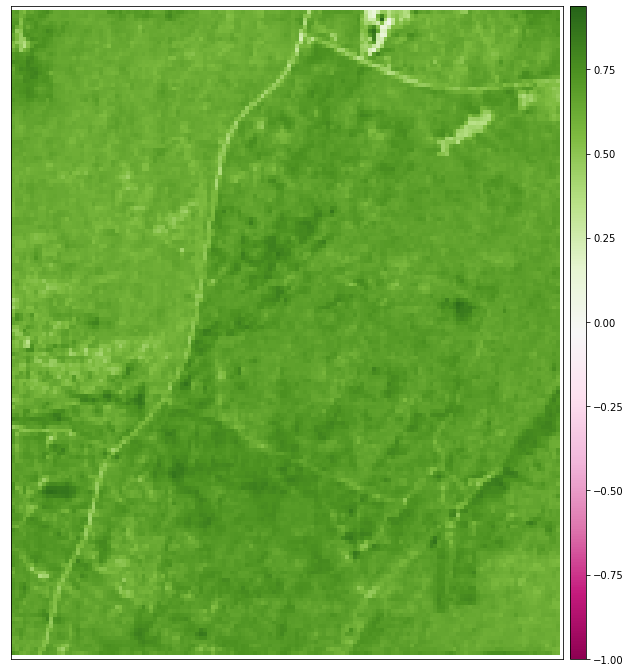

In [51]:
# You will want to grab a mean value but this is just a demo
ep.plot_bands(ndvi_2,
              cmap='PiYG',
              vmin=-1)
plt.show()

Almost  done -  time to crop your NDVI data using the function that you created above.  
For the purposes fo your homework - you could consider returning a mean NDVI value for the clipped data
as an option. 
 

In [62]:
# Open up the cloud mask layer

# Cloud no data vals for Landsat 8 -
high_cloud_confidence = (
    em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"])
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence

# Open cloud mask layer
pixel_qa_path = glob(os.path.join(adir, "*qa*"))

# Open and clip the cloud mask layer
cl_mask = (rxr.open_rasterio(pixel_qa_path[0], masked=True)
           .rio.clip(crop_bound.geometry, from_disk=True)
           .squeeze())

# View unique values in the data
# Note that not every landsat band will have clouds to mask
# Note also  that there are NAN's here because the data were clipped
np.unique(cl_mask.values)

array([322., 324.,  nan])

## Create Final NDVI data

Note that for your homework you are working towards a mean NDVI value so there is another step.
You could decide to add that step to the NDVI function `mask_crop_ndvi` as an option!


For each scene you will need to:
    
1. calculate NDVI
2. Clip the data and 
3. apply the cloud mask

You  may want to calculate a mean as well in this function.

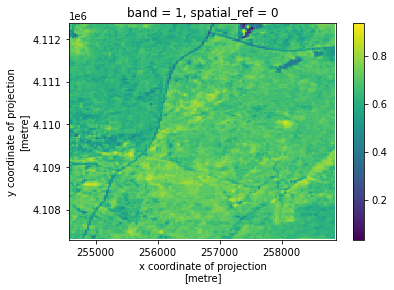

In [63]:
#  Calculate NDVI
ndvi_xr = (all_bands[1]-all_bands[0]) / (all_bands[1]+all_bands[0])

# Apply cloud mask to NDVI
ndvi_crop = ndvi_xr.where(~cl_mask.isin(all_masked_values))

# Plot
ndvi_crop.plot()

The function below has more comments than you need. I've added them to it
is clear what each line does. 

In [56]:
# Turn  the above into a function
#  This could also easily be two functions
def mask_crop_ndvi(all_bands,
                   crop_bound,
                   pixel_qa_path,
                   vals):
    """Open and mask a single landsat band using a pixel_qa layer.

    Parameters
    -----------
    all_bands : list
        A list containing two xarray objects for landsat bands 4 and  5
    crop_bound : geopandas GeoDataFrame
        A geopandas dataframe to be used to crop the raster data using 
        rasterio mask().
    pixel_qa_path : string
        A path to a pixel qa tif file.
    vals : list
        A list of values needed to create the cloud mask


    Returns
    -----------
    ndvi_mask : xarray.DataArray
        a cropped and masked xarray object containing NDVI values
    """
    
    crop_json = crop_bound.geometry

    # Open and clip qa layer
    pixel_qa = (rxr.open_rasterio(pixel_qa_path[0], masked=True)
                .rio.clip(crop_json, from_disk=True)
                .squeeze())
    

    # Calculate NDVI
    ndvi_xr = (all_bands[1]-all_bands[0]) / (all_bands[1]+all_bands[0])

    # Apply cloud mask to NDVI
    ndvi_mask = ndvi_xr.where(~pixel_qa.isin(vals))

    return ndvi_mask

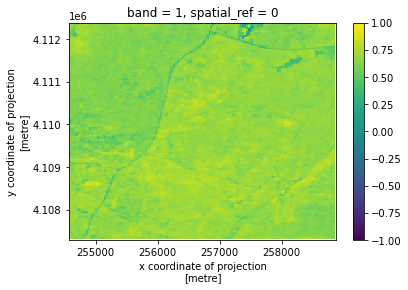

In [64]:
ndvi_clean = mask_crop_ndvi(all_bands=all_bands,
                            crop_bound=crop_bound,
                            pixel_qa_path=pixel_qa_path,
                            vals=all_masked_values)

# View the final, cropped & cleaned NDVI data
ndvi_clean.plot.imshow(vmin=-1,
                       vmax=1)
plt.show()

# As you start working with larger datasets, it's important to be efficient
We made a few choices in this workflow that could affect performance. Let's use timeit to figure out which ones are the best.

## Piping vs not piping commands

Not huge gains, but it does seem like piping is recommended by the rioxarray developer and a bit faster.

In [72]:
%%timeit
# Speed tests

# Open a single band using rioxarray and crop in a different line of code
band = rxr.open_rasterio(band_paths[0], masked=True).squeeze()
band = band.rio.clip(crop_bound.geometry)

28.8 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
%%timeit
# Speed tests - clip chained to open data - not too different

# Open and clip a single band using rioxarray
band = (rxr.open_rasterio(band_paths[0], masked=True)
        .rio.clip(crop_bound.geometry)
        .squeeze())

28.7 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## From_disk rioxarray parameter to read only the data you need from disk 

I believe this is effectively slicing the data. The `from_disk` option 
definitely speeds things up - from_disk then only loads the data that you need (the clipped data)

Note that you need to have rioxarray version 0.2 or greater for `from_disk` to be available. 


In [75]:
%%timeit
# Speed tests - Clip using from_disk parameter

# Open a single band using rioxarray
band = (rxr.open_rasterio(band_paths[0], masked=True)
        .rio.clip(crop_bound.geometry, from_disk=True)
        .squeeze())

6.27 ms ± 68.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Pyproj settings bring big speed gains

Below we use **pyproj** settings to speed things up even more. This speed difference is SIGNIFICANT!
However we need to research more when this setting would get us into trouble. 

In [76]:
# This import should be at the top of your notebook
import pyproj

In [77]:
%%timeit
# Now this is super speedy!

# Use with caution - you must  have pyproject 3.0 or greater for this to work
pyproj.set_use_global_context(True)


# Open a single band using rioxarray - from_disk requires rioxarray  0.2
band = (rxr.open_rasterio(band_paths[0], masked=True)
        .rio.clip(crop_bound.geometry, from_disk=True)
        .squeeze())

6.27 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%%timeit
# Is it faster to calculate NDVI and mask / clip after OR clip bands first

all_bands = []
for aband in band_paths:
    #print("Opening up", aband)
    # This function
    band = rxr.open_rasterio(aband, masked=True).squeeze()

    # Only run this step if a valid range tuple is provided
    if valid_range:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    all_bands.append(cleaned_band)


# Calculate NDVI & clip /  mask
crop_json = crop_bound.geometry

# Open pixel qa layer
pixel_qa = (rxr.open_rasterio(pixel_qa_path[0], masked=True)
            .rio.clip(crop_json)
            .squeeze())

# Calculate NDVI on the larger image
ndvi_xr = (all_bands[1]-all_bands[0]) / (all_bands[1]+all_bands[0])

# Clip NDVI layer
ndvi_crop = ndvi_xr.rio.clip(crop_json,
                             from_disk=True)

# Apply cloud mask to NDVI
ndvi_crop = ndvi_crop.where(~pixel_qa.isin(vals))

83.2 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%%timeit

# Here I clip the data and then calculate NDVI and then mask NDVI

# Calculate NDVI & clip / mask
crop_json = crop_bound.geometry

# Open bands
all_bands = []
for aband in band_paths:
    band = (rxr.open_rasterio(aband, masked=True)
            .rio.clip(crop_json, from_disk=True)
            .squeeze())

    # Only run this step if a valid range tuple is provided
    if valid_range:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    all_bands.append(cleaned_band)


# Open pixel qa layer
pixel_qa = rxr.open_rasterio(
    pixel_qa_path[0], masked=True).rio.clip(crop_json).squeeze()

# Calculate NDVI on the larger image
ndvi_xr = (all_bands[1]-all_bands[0]) / (all_bands[1]+all_bands[0])

# Clip NDVI layer
ndvi_crop = ndvi_xr.rio.clip(crop_json, from_disk=True)

# Apply cloud mask to NDVI
ndvi_crop = ndvi_xr.where(~pixel_qa.isin(vals))

56.1 ms ± 5.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


##  A bit slower to mask both bands first 

It seems just a bit slower to mask each band individually.



In [29]:
%%timeit

# Or here I clip and mask everything first
# Then calculate NDVI


# Calculate NDVI & clip /  mask
crop_json = crop_bound.geometry

# Open pixel qa layer
pixel_qa = rxr.open_rasterio(
    pixel_qa_path[0], masked=True).rio.clip(crop_json).squeeze()

all_bands = []
for aband in band_paths:
    #print("Opening up", aband)
    # This function
    band = rxr.open_rasterio(aband, masked=True).rio.clip(crop_json,
                                                          from_disk=True).squeeze()

    band = band.where(~pixel_qa.isin(vals))

    # Only run this step if a valid range tuple is provided
    if valid_range:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    all_bands.append(cleaned_band)


# Calculate NDVI on the larger image
ndvi_xr = (all_bands[1]-all_bands[0]) / (all_bands[1]+all_bands[0])

60.3 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


##  Conclusions

Things that speed things up:

1. Clip the data using `from_disk` when you open it. This I believe it like slicing where it's only grabbing the data t hat you need saving time a nd memory resources
2. Use the pyproj global context: Still looking into when this might be problematic - will ask on rioxarray
3. Apply the cloud mask to the data at the end to the final NDVI calculation. This way you are only masking the data once. 